### Simulation Data Aggregation


In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from lens_simulation import utils
# path = r"\\ad.monash.edu\home\User028\pcle0002\Documents\repos\lens_simulation\src\lens_simulation\log\duly-fancy-panda\sweet-mako"
pd.set_option("display.max_rows", None, "display.max_columns", None)

directory = r"\\ad.monash.edu\home\User028\pcle0002\Documents\repos\lens_simulation\src\lens_simulation\log\barely-ideal-zebra"
directory = r"\\ad.monash.edu\home\User028\pcle0002\Documents\repos\lens_simulation\src\lens_simulation\log\lively-vital-duck"


df = utils.load_run_simulation_data(directory)

print(f"run: {os.path.basename(directory)}")
display(df.T)


df.to_csv("data.csv")

In [ ]:
display(df[df["exponent"] ==  2.1].T)


## Simulation Parameter Sweep


In [ ]:
%load_ext autoreload
%autoreload 2

from lens_simulation import utils
from pprint import pprint
from copy import deepcopy

# sweep
config = utils.load_config("config.yaml")

config["sweep"] = deepcopy(config)

pprint(config)


# config dict vs config yaml
# yaml creates the sweeps
# dicts create the objects




In [ ]:
%load_ext autoreload
%autoreload 2

%load_ext autoreload 
%autoreload 2
from lens_simulation import SimulationRunner


sim_runner = SimulationRunner.SimulationRunner("sweep.yaml")
# sim_runner.initialise_simulation()
sim_runner.setup_simulation()
# sim_runner.run_simulations()


In [1]:
%load_ext autoreload
%autoreload 2
from lens_simulation.SimulationRunner import (get_lens_configurations, generate_lens_parameter_combinations, 
    generate_beam_parameter_combinations,  get_beam_configurations, generate_stage_parameter_combination, get_stage_configurations, 
    generate_simulation_parameter_sweep, sweep_custom_profiles)
from lens_simulation import utils
from lens_simulation.constants import LENS_SWEEPABLE_KEYS, MODIFICATION_SWEEPABLE_KEYS, BEAM_SWEEPABLE_KEYS, STAGE_SWEEPABLE_KEYS, GRATING_SWEEPABLE_KEYS, TRUNCATION_SWEEPABLE_KEYS, APERTURE_SWEEPABLE_KEYS
from lens_simulation import validation
from pprint import pprint
from copy import deepcopy


In [12]:
config = utils.load_config("config.yaml")
info =  {"run_id": 9999, "run_petname": "test-carry-mule", "log_dir": "log"}


lc = config["lenses"][0]

# print("profiles:")
# pprint(lc["custom"])
# print("-"*50)
cp = sweep_custom_profiles(lc["custom"])

# print("custom_params: ", cp)

simulation_configurations = generate_simulation_parameter_sweep(config, info)

for sc in simulation_configurations:
    print("-"*50)
    for lc in sc["lenses"]:
        pprint(lc["custom"])

--------------------------------------------------
None
None


In [ ]:
from lens_simulation.Lens import generate_lens
from lens_simulation.Medium import Medium
from lens_simulation import utils
import matplotlib.pyplot as plt

for conf in simulation_configurations:

    # pprint(conf)
    lc = conf["lenses"][0]
    lens = generate_lens(lc, Medium(lc["medium"]), conf["sim_parameters"]["pixel_size"])

    plotting.plot_lens_profile_2d(lens)
    plt.show()

    plotting.plot_lens_profile_slices(lens)
    plt.show()



In [ ]:
directory = r"\\ad.monash.edu\home\User028\pcle0002\Documents\repos\lens_simulation\src\lens_simulation\log\hugely-subtle-drake"
df = utils.load_run_simulation_data(directory)

display(df.T)

### ZARR


In [ ]:
import zarr
z = zarr.zeros((10000, 10000), chunks=(1000, 1000), dtype='i4')
print(z.info)

z1 = zarr.open('data/example.zarr', mode='w', shape=(10000, 10000), chunks=(1000, 1000), dtype='i4')

In [ ]:
import numpy as np
a = np.arange(10)
zarr.save('data/example.zarr', a)
zarr.load('data/example.zarr')

### New Simulation Config


In [25]:
%load_ext autoreload
%autoreload 2

from lens_simulation import utils
from pprint import pprint
from lens_simulation.beam import load_beam_config
from lens_simulation.Simulation import generate_simulation_options, generate_simulation_parameters, load_sim_stage_config
from lens_simulation.structures import SimulationConfig
from lens_simulation.Lens import load_lens_config
config = utils.load_config("sweep.yaml")
# conf_v2 = utils.load_config_struct("sweep.yaml")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:

beam_settings = load_beam_config(config["beam"])

lenses = [load_lens_config(lc) for lc in config["lenses"]]
stages = [load_sim_stage_config(sc) for sc in config["stages"]]

options = generate_simulation_options(config, "log")
parameters = generate_simulation_parameters(config)


sim_config = SimulationConfig(
    beam=beam_settings,
    lenses=lenses,
    stages=stages,
    parameters=parameters,
    options=options
)


print("SIM CONFIG:")
pprint(sim_config.beam)
print("-"*50)
pprint(sim_config.lenses)
print("-"*50)
pprint(sim_config.stages)
print("-"*50)
pprint(sim_config.parameters)
print("-"*50)
pprint(sim_config.options)



SIM CONFIG:
BeamSettings(distance_mode=<DistanceMode.Direct: 1>, beam_spread=<BeamSpread.Plane: 1>, beam_shape=<BeamShape.Circular: 1>, width=0.0001, height=0.0001, position_x=0.0, position_y=0.0, theta=0.0, numerical_aperture=None, tilt_x=0.0, tilt_y=0.0, source_distance=0.002, final_diameter=None, focal_multiple=None, n_steps=10, step_size=0, output_medium=1.0)
--------------------------------------------------
[LensSettings(diameter=0.0003, height=1e-05, exponent=2.0, medium=Medium(), lens_type=<LensType.Spherical: 2>, length=None, custom='None', escape_path=None, inverted=False, grating=GratingSettings(width=1e-05, distance=2e-05, depth=1.5e-07, axis=1, centred=True, distance_px=None, width_px=None), truncation=TruncationSettings(type='value', height=3e-06, radius=5e-05, aperture=False), aperture=ApertureSettings(type='radial', inner=5e-05, outer=0.0001, invert=False)),
 LensSettings(diameter=0.0003, height=1e-05, exponent=2.4, medium=Medium(), lens_type=<LensType.Spherical: 2>, le

### DASK Experiments


In [6]:
import time
import dask


@dask.delayed
def inc(x):
    time.sleep(1)
    return x + 1

@dask.delayed
def add(x, y):
    time.sleep(1)
    return x + y

'\\ad.monash.edu\home\User028\pcle0002\Documents\repos\lens_simulation\src\lens_simulation'
CMD.EXE was started with the above path as the current directory.
UNC paths are not supported.  Defaulting to Windows directory.


CPU times: total: 62.5 ms
Wall time: 289 ms


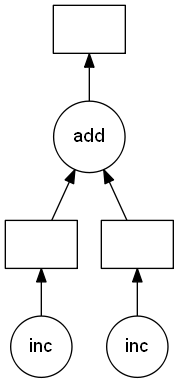

In [10]:
%%time

a = inc(1)
b = inc(1)
c = add(a, b)
c.visualize("mydask.png")
# c.dask
# c = c.compute()


In [5]:
%load_ext autoreload
%autoreload 2

from lens_simulation import utils, plotting

path = r"C:\Users\pcle0002\Documents\repos\lens_simulation\src\lens_simulation\log\firmly-humble-jay\well-bedbug\1"
plotting.save_propagation_gif(path)

Lossy conversion from float64 to uint8. Range [0.0, 747426368.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [5.550999730985495e-07, 4120070656.0]. Convert image to uint8 prior to saving to suppress this warning.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Lossy conversion from float64 to uint8. Range [0.0836464986205101, 578084601856.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [1.2544015645980835, 5144733184.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [5.952335357666016, 1032039552.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [5.693484306335449, 441686048.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [33.145912170410156, 261790784.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [121.01366424560547, 165076544.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [831.030517578125, 138414832.0]. Convert image to uint8 prior to saving to 